### Preparación del modelo

In [55]:
import torch

# Descargamos el modelo y lo "ajustamos"
model = torch.hub.load(
    'ultralytics/yolov5', 'custom', path="modelo_ines_entrenado.pt"
)
model.eval()

Using cache found in C:\Users\HV/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-3-31 Python-3.12.2 torch-2.2.2+cpu CPU

Fusing layers... 
Model summary: 267 layers, 46129818 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1

### Trabajar con la imágen

In [61]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

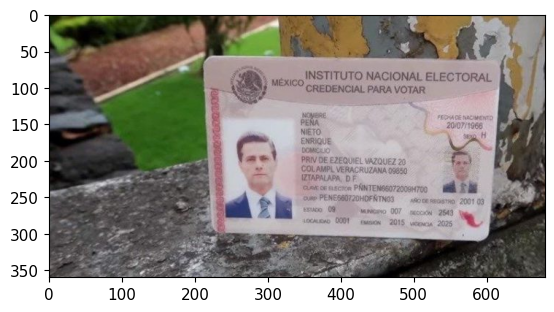

In [76]:
# Cargamos y mostramos
img_ine_path = "ines_test/prueba_03.jpg"
image = cv2.imread(img_ine_path)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

,xmin,ymin,xmax,ymax,confidence,class,box_name,palabras_identificadoras
0,340,179,496,229,0.938083,0,address,domicilio
1,339,130,407,180,0.926856,4,name,nombre
2,527,131,613,159,0.918324,3,dob,fecha de nacimiento
3,345,245,479,261,0.905975,2,curp,curp
4,344,230,521,245,0.849555,1,clave_de_elector,clave de elector


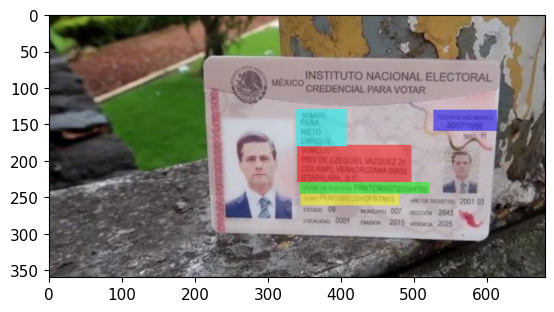

In [77]:
# Trabajamos con la imágen
results = model(img_rgb)
pd_boxes = results.pandas().xyxy[0]
pd_boxes.rename(columns={"name": "box_name"}, inplace=True)

# una columna para poder identificar si la clase es correcta
def condition_palabras_id(x):
    if x==0:
        return "domicilio"
    elif x==1:
        return "clave de elector"
    elif x==2:
        return "curp"
    elif x==3:
        return "fecha de nacimiento"
    elif x==4:
        return "nombre"
    else:
        return "error"

pd_boxes["palabras_identificadoras"] = pd_boxes["class"].apply(
    condition_palabras_id
)

# Truncamos y redondeamos los valores
pd_boxes['xmin'] = np.floor(pd_boxes.xmin).astype(int)
pd_boxes['ymin'] = np.floor(pd_boxes.ymin).astype(int)

pd_boxes['xmax'] = np.ceil(pd_boxes.xmax).astype(int)
pd_boxes['ymax'] = np.ceil(pd_boxes.ymax).astype(int)
display(pd_boxes)

# Dibujamos las cajas
overlay = img_rgb.copy()

box_name_colors = {
    "address": (255,0,0),
    "clave_de_elector": (0,255,0),
    "dob": (0,0,255),
    "curp": (255,255,0),
    "name": (0,255,255)
}

for index, row in pd_boxes.iterrows():
    cv2.rectangle(
        overlay,
        (row.xmin, row.ymin),
        (row.xmax, row.ymax),
        color=box_name_colors[row.box_name],
        thickness=-1
    )

alpha = 0.5

plt.imshow(
    cv2.addWeighted(overlay, alpha, img_rgb, 1 - alpha, 0)
)
plt.show()


#### Un poco de CV, OCR

In [78]:
import easyocr
from difflib import SequenceMatcher
reader = easyocr.Reader(["es"], gpu=False)
import numpy as np

Using CPU. Note: This module is much faster with a GPU.


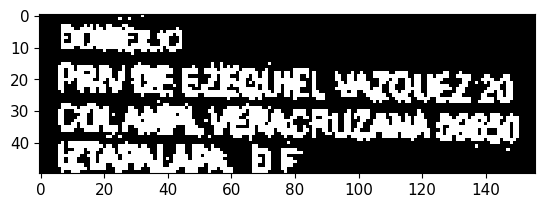

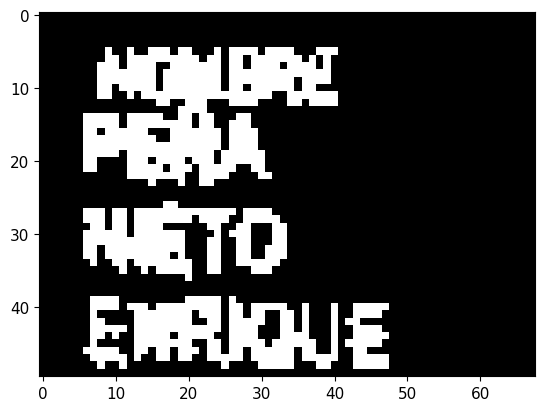

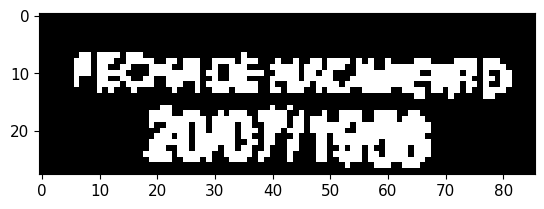

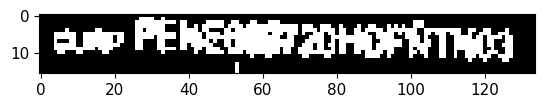

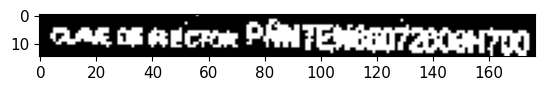

,xmin,ymin,xmax,ymax,confidence,class,box_name,palabras_identificadoras,ratio_palabras_id,texto_ocr
0,340,179,496,229,0.938083,0,address,domicilio,0.285714,"[DoNrn, Eu, EZECUEL Wa7Qurz2, L1, Veacruzhtgn,..."
1,339,130,407,180,0.926856,4,name,nombre,0.200000,"[PEeR, Hito, ElakuE]"
2,527,131,613,159,0.918324,3,dob,fecha de nacimiento,0.384615,"[Fboedea 536, 40o1tedg]"
3,345,245,479,261,0.905975,2,curp,curp,0.000000,"[Fekse, HacHoFvT7a]"
4,344,230,521,245,0.849555,1,clave_de_elector,clave de elector,0.181818,"[0#ecFk, PaN7E 85o7zoah7m]"


In [79]:
list_ratio_palabras_id = []
list_ocr_box = []

def k_channelizer(input_image):
    # Convert to float and divide by 255:
    img_float = input_image.astype(float) / 255.

    # Calculate channel K:
    k_channel = 1 - np.max(img_float, axis=2)

    # Convert back to uint 8:
    k_channel = (255 * k_channel).astype(np.uint8)

    return k_channel

for _, item_box in pd_boxes.iterrows():
    cropped = image[item_box.ymin:item_box.ymax, item_box.xmin:item_box.xmax]
    cropped_gray = k_channelizer(cropped)

    # Este para credenciales más nuevas
    _, curr_th = cv2.threshold(cropped_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Este es bueno para credenciales más viejas
    #curr_th = cv2.adaptiveThreshold(cropped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 3)

    # Remoción de áreas pequeñas
    # cnts = cv2.findContours(curr_th.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # mask = np.ones(curr_th.shape[:2], dtype="uint8") * 255
    # # loop over the contours
    # for c in cnts[0]:
    #     # if the contour is bad, draw it on the mask
    #     if cv2.contourArea(c)<=15:
    #         cv2.drawContours(mask, [c], -1, 0, -1)

    # image_cleaned = cv2.bitwise_and(~curr_th, ~curr_th, mask=mask)

    image_cleaned = curr_th

    # Dilación para conectar
    # dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) #np.ones((1,1),np.uint8)
    # dilated_image = cv2.dilate(image_cleaned, dilation_kernel,iterations = 1)

    # OCR reading
    curr_ocr_result = reader.readtext(image_cleaned, detail=0)
    list_ocr_box.append(
        curr_ocr_result
    )
    
    sequence_matcher = SequenceMatcher(
        None, "".join(curr_ocr_result[0].lower().split()), item_box.palabras_identificadoras
    ).ratio()

    palabra_split = SequenceMatcher(
        None,
        "".join(curr_ocr_result[0].split()[0].lower().split()),
        item_box.palabras_identificadoras
    ).ratio()

    list_ratio_palabras_id.append(
        np.max([sequence_matcher, palabra_split])
    )
    
    plt.imshow(image_cleaned, cmap="gray")
    plt.show()

pd_boxes["ratio_palabras_id"] = list_ratio_palabras_id
pd_boxes["texto_ocr"] = list_ocr_box

pd_boxes
